In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("msft_stock1.csv")
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2020-01-02,160.729996,158.330002,158.779999,160.619995,22622100.0,158.571075
1,2020-01-03,159.949997,158.059998,158.320007,158.619995,21116200.0,156.596588
2,2020-01-06,159.100006,156.509995,157.080002,159.029999,20813700.0,157.001373
3,2020-01-07,159.669998,157.320007,159.320007,157.580002,21634100.0,155.569855
4,2020-01-08,160.800003,157.949997,158.929993,160.089996,27746500.0,158.047836


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))

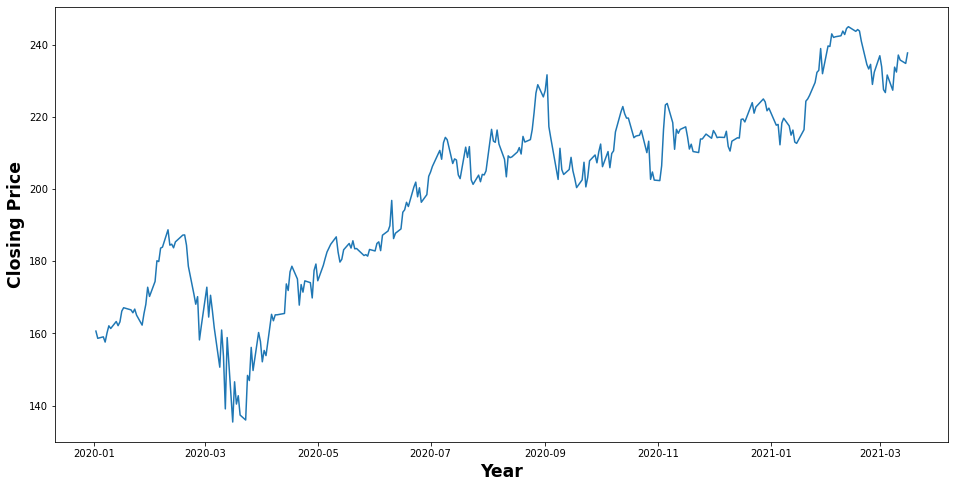

In [4]:
df["Date"]=pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
plt.xlabel("Year", fontsize='xx-large', fontweight='bold')
plt.ylabel("Closing Price", fontsize='xx-large', fontweight='bold')
plt.show()

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [6]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
new_dataset.head()
new_dataset.columns

Index(['Date', 'Close'], dtype='object')

In [7]:
new_dataset = new_dataset.set_index(['Date'])
#new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:200,:]
valid_data=final_dataset[200:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [8]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

140/140 - 3s - loss: 0.0147


In [9]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1], 1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [10]:
lstm_model.save("saved_model.h5")

<ipython-input-12-0b74332bb639>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


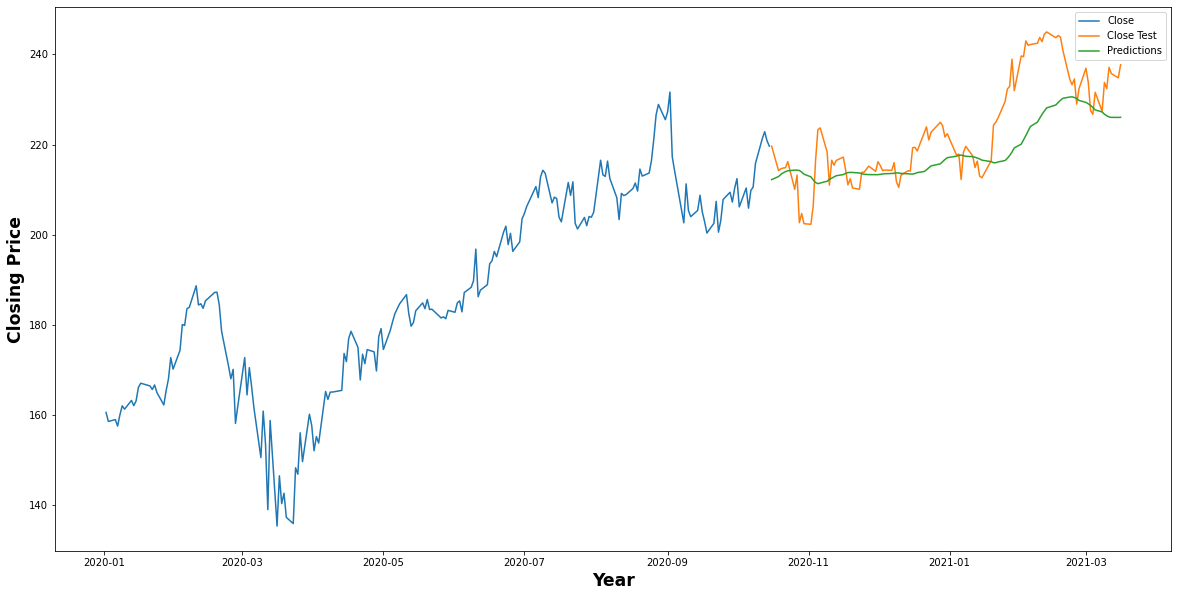

In [12]:
train_data=new_dataset[:200]
valid_data=new_dataset[200:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
plt.xlabel("Year", fontsize='xx-large', fontweight='bold')
plt.ylabel("Closing Price", fontsize='xx-large', fontweight='bold')
plt.legend(['Close', 'Close Test', 'Predictions'])
plt.savefig('msft_stock.png')
plt.show()